In [1]:
import requests
import json
import pandas as pd
import time
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import api_key

In [2]:
def get_sensor_info(id):
    """Returns geographic data for given PurpleAir sensor"""
    sensor_base = "https://api.purpleair.com/v1/sensors/"
    headers = {"X-API-KEY": api_key.read}
    params = {"fields": "latitude,longitude"}
    
    url = sensor_base + str(id)
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        sensor_data = pd.DataFrame(response.json())
        return sensor_data
    else:
        print(id)
        print("Failed to retrieve data")

In [3]:
sensors = [1848, 2713, 6836, 17793, 23253, 27099, 33013, 36587, 40835, 67241, 78637, 81065, 83227, 98775, 114261, 148547, 154297, 216023, 224015, 243017, 244053, 256493, 257621, 260741, 260839, 261751, 265501]

In [4]:
geo_data = pd.DataFrame()
for sensor in sensors:
    sensor_info = get_sensor_info(sensor)
    sensor_data = sensor_info["sensor"]
    if geo_data.empty:
        geo_data = pd.DataFrame(sensor_data).T.reset_index(drop=True)
    else:
        geo_data = pd.concat([geo_data, sensor_data.to_frame().T]).reset_index(drop=True)
geo_data

,sensor_index,latitude,longitude
0,1848.0,34.141758,-118.060745
1,2713.0,34.071632,-118.031260
2,6836.0,33.935528,-118.168510
3,17793.0,34.104240,-118.331700
4,23253.0,34.061237,-118.116520
5,27099.0,33.980984,-118.340454
6,33013.0,34.175926,-118.450874
7,36587.0,34.200916,-118.323700
8,40835.0,33.843872,-118.345566
9,67241.0,34.090786,-118.242840


In [5]:
def get_sensor_history(id):
    """Returns pm2.5 yearly average from 2023-2024 for given PurpleAir sensor"""
    headers = {"X-API-KEY": api_key.read}
    params = {"fields": "pm2.5_atm"}
    start = 1678838400  # Mar 15, 2023
    end = 1710460800    # Mar 15, 2024
    average = 525600    # Yearly
    
    url = f"https://api.purpleair.com/v1/sensors/{id}/history?start_timestamp={start}&end_timestamp={end}&average={average}"
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        initial_data = response.json()
        sensor_index = initial_data["sensor_index"]
        data_extract = pd.DataFrame(initial_data["data"])  # data has two values, timestamp and pm2.5
        if not data_extract.empty:
            pm = data_extract[1]  # extract pm2.5
            sensor_data = pd.DataFrame({"sensor_index": sensor_index, "pm2.5_atm": pm})
            return sensor_data
    else:
        print(id)
        print(response)

In [6]:
pm_data = pd.DataFrame()
for sensor in sensors:
    sensor_history = get_sensor_history(sensor)
    if pm_data.empty:
        pm_data = sensor_history
    else:
        pm_data = pd.concat([pm_data, sensor_history]).reset_index(drop=True)
    time.sleep(5)  # avoid rate limit
pm_data

,sensor_index,pm2.5_atm
0,1848,12.2420
1,2713,13.3605
2,6836,11.9285
3,17793,10.7210
4,23253,14.9280
5,27099,9.5760
6,36587,66.0780
7,67241,14.5190
8,78637,13.6730
9,81065,12.6225


In [7]:
combined_data = geo_data.merge(pm_data, on="sensor_index")
combined_data

,sensor_index,latitude,longitude,pm2.5_atm
0,1848.0,34.141758,-118.060745,12.2420
1,2713.0,34.071632,-118.031260,13.3605
2,6836.0,33.935528,-118.168510,11.9285
3,17793.0,34.104240,-118.331700,10.7210
4,23253.0,34.061237,-118.116520,14.9280
5,27099.0,33.980984,-118.340454,9.5760
6,36587.0,34.200916,-118.323700,66.0780
7,67241.0,34.090786,-118.242840,14.5190
8,78637.0,33.903923,-118.053440,13.6730
9,81065.0,33.818794,-118.123350,12.6225


In [8]:
combined_data = combined_data.drop(6)  # remove outlier

In [9]:
street_map = gpd.read_file("lacounty/County_Boundary.shp")

In [10]:
crs = "EPSG:4326"  # designate coordinate system
geometry = [Point(xy) for xy in zip(combined_data["longitude"], combined_data["latitude"])]
geo_df = gpd.GeoDataFrame(combined_data, crs=crs, geometry=geometry)
geo_df.head()

,sensor_index,latitude,longitude,pm2.5_atm,geometry
0,1848.0,34.141758,-118.060745,12.2420,POINT (-118.06 34.142)
1,2713.0,34.071632,-118.031260,13.3605,POINT (-118.03 34.072)
2,6836.0,33.935528,-118.168510,11.9285,POINT (-118.17 33.936)
3,17793.0,34.104240,-118.331700,10.7210,POINT (-118.33 34.104)
4,23253.0,34.061237,-118.116520,14.9280,POINT (-118.12 34.061)


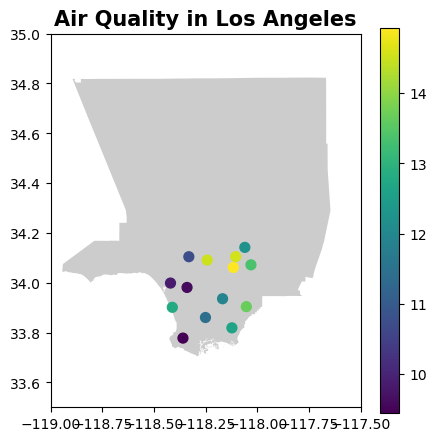

In [11]:
street_map = street_map.to_crs(geo_df.crs)  # match the projection
fig, ax = plt.subplots(figsize=(5,5))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(column="pm2.5_atm", ax=ax, legend=True, markersize=50)
plt.title("Air Quality in Los Angeles", fontsize=15, fontweight="bold")
plt.xlim(-119, -117.5)
plt.ylim(33.5, 35)
plt.show()